In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

# Computational cost of the ANOVA kernel

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter 
    <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/">extensions</a>.
</div>

In [1]:
# Packages
import numpy  as np
import pandas as pd
import scipy.sparse as sparse

import numba
from   numba import jit

import time
import itertools

#import imageio
#from   skimage.transform import resize
from   skimage.metrics   import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
import matplotlib.pyplot as plt

import skimage.io    as io
import skimage.color as color
from   skimage              import data_dir
from   skimage.transform    import resize
from   mpl_toolkits.mplot3d import Axes3D
from   matplotlib           import cm
from   matplotlib.ticker    import LinearLocator, FormatStrFormatter, MultipleLocator

<div class="alert alert-block alert-success">
We build up code to later solve the following problem:
\begin{align*}
        &\min \dfrac{1}{2} \|u-u^T\|^2_{0,\Omega} =: f(\lambda)
    \\
    \text{subject to}\qquad
    \\
        & (u,\phi)_V + \big( \lambda(u-f), \phi \big) = 0, &\forall \phi \in V.
\end{align*}
</div>

$\DeclareMathOperator{\AK}{\mathrm{AK}_\sigma}$
The nonlocal product $(u,\phi)_V$ is defined as
\begin{align}
    (u,\phi)_V = ( u \AK \mathbb{1} - \AK u, \phi )_{L^2(\Omega)}.
\end{align}
Here $\AK$ represents the unnormalised _extended Gaussian ANOVA kernel_, which in turn is given by:
\begin{align}
    \AK u (x) = \sum_{\ell=1}^L \frac{1}{L} \int_\Omega u(y)\, e^{-\sigma^{-2} \big\| \mathcal{W}_\ell [f](x) - \mathcal{W}_\ell [f](y) \big\|^2}  \mathrm{d}y,
\end{align}
where $\sigma$ is a shape parameter, $L$ is the number of kernels to combine, and $\mathcal{W}_\ell = \{ w_1^\ell, w_2^\ell, w_3^\ell \} \in \{ 1, \dots, d \}^3$ are patches of features, so that $\mathcal{W}_\ell [f](x)$ and $\mathcal{W}_\ell [f](y)$ are the data points restricted to the corresponding features. 
The normalised version of this kernel is given by the quotient $\AK u / \AK \mathbb{1}$. In this notebook we will explore the use of the nonequispaced spherical transform to compute $\AK u$ and its use for image denoising tasks.
We have a weighted sum of multiple kernels, where every kernel relies on not more than 3 features and, thus, we can apply the NFFT-based fast summation approach and use the [`fastadj`](https://github.com/dominikalfke/FastAdjacency) package by Dominik Alfke to speed up the kernel-vector multiplication.

The nonequispaced Gauss transform computes, for a given $d$-dimensional *point cloud* of $n$ points $x_i \in \mathbb{R}^d$, $i=1,\ldots,n$, the action of the operator
\begin{align}
A = (a_{ij})_{i,j=1}^n \in \mathbb{R}^{n \times n}, \qquad A_{ij} = \exp\left(\frac{-\|x_i - x_j\|^2}{\sigma^2}\right).
\end{align}

We will apply the extended Gaussian ANOVA toolkit [`nfft4anova`](https://github.com/wagnertheresa/NFFT4ANOVA) by Theresa Wagner to determine $L$ and the feature patches $\mathcal{W}_\ell [f]$.

In [2]:
import fastadj

In [3]:
"""Local packages"""
from sys import path
path.insert(0, 'NFFT4ANOVA/nfft4anova')
from nfft_kernel_ridge import NFFTKernelRidge        # extended Gaussian ANOVA computation toolbox

In [4]:
# Aliases
from scipy.sparse.linalg import LinearOperator, minres
from scipy.sparse        import csr_matrix
from scipy.optimize      import Bounds, minimize
from imageio             import imwrite, imread
from pandas              import DataFrame
# Numpy aliases
from numpy import linspace, pad, broadcast_to
from numpy.lib.stride_tricks import sliding_window_view

from numpy        import asarray, logspace, sqrt, clip, around, array, square, ravel, empty, meshgrid
from numpy        import multiply, add, reciprocal, subtract, empty_like, stack, arange
from numpy        import zeros, append, diagflat, triu, tril, logical_and, where, ones, minimum, allclose
from numpy.linalg import inv, norm
from numpy.random import default_rng
lsolver     = sparse.linalg.lgmres

In [5]:
# More aliases
from scipy.stats import describe
from skimage           import data, img_as_float
from skimage.io        import imsave
from skimage.transform import rescale

<div class="alert alert-block alert-info">
We load one image from the data set.
</div>

In [6]:
image = data.brain()[9]

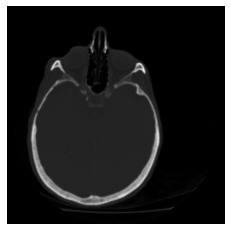

In [7]:
#imsave('brain.png', image)
plt.imshow(image, cmap='gray');    plt.axis('off');    plt.show()

In [8]:
image = 255 * img_as_float(image)

# Operator time

We will loop over different image sizes and collect set-up time and operator time:

In [9]:
clf = NFFTKernelRidge(sigma=1.0, norm = None, setup = 'default')    # Instiatate the kernel ridge inner functions

In [10]:
Scales = np.r_[np.logspace(-4,1.6,15, base = 2.0),3.91]

In [11]:
from sklearn.metrics.pairwise import rbf_kernel

### $\rho=3$

In [12]:
dims_images = []
n_dimensions = []
L_sizes = []

Patch_creation = []
Window_finder = []
Subkernel_time = []
Operator_time = []
Full_Kernel_time = []
ANOVA_time = []

print('–'*100)
for scale in Scales:
    # Scale image
    img = rescale(image, scale, anti_aliasing=True)
    img = asarray(img).astype(float, copy = False)
    N,M = img.shape
    nm  = img.size
    print(N,M,nm)
    dims_images.append((N,M))
    n_dimensions.append(nm)
    
    # Create noisy sample
    ## Fix seed
    rng = default_rng(10)
    σ_i = logspace(1,3,5)[3]
    f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f)
    print('{0:10} -> {1}'.format( around(σ_i,2), around(ssim(img, f, data_range=f.max()-f.min() ),2)  ))
    
    # Patch radius
    ρ = 3
    
    # Determine number of times for sampling times
    if scale < Scales[9]:
        reps = 100
    elif scale < Scales[11]:
        reps = 50
    elif scale < Scales[-1]:
        reps = 20
    else:
        reps = 10
    
    
    '''
        Kernel Setup
    '''
    def SSIM(img,u, N,M):  return ssim(img, u.reshape(N,M), data_range=u.max()-u.min())
    
    ρ̂    = 2*ρ+1
    
    """Patches"""
    start = time.time()
    Fᵖᵃᵈ = pad(f, ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    end = time.time()
    Patch_creation.append(end-start)
    
    '''Build windows'''
    window_scheme = 'mis'
    start = time.time()
    # determine windows of features by their mis
    if window_scheme == 'mis':
        res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
        windows = clf.get_mis_windows(res_idx)

    # windows are built following the feature indices in ascending order
    elif window_scheme == 'consec':
        d    = X.shape[1]
        windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

        # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
        if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

    # use predefined list of windows of features
    elif window_scheme == None:
        windows = pre_list
    end = time.time()
    
    num_windows = len(windows)
    Window_finder.append(end-start)
    L_sizes.append(num_windows)
    
    '''Weights'''
    # Select weight creation mode
    weight_scheme = 'equally weighted'

    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

    # Store weights efficiently as a view
    weights = broadcast_to(k_weight, (num_windows, ))
    
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows)]
    σ = 30.0
    
    aver = 0.0
    for re in range(reps):
        start = time.time()
        SubKernels = W(σ, Other_Setup = 'default')
        end = time.time()
        aver += (end-start)
    aver /= reps
    
    Subkernel_time.append(aver)

    def AK(u):
        """
        Approximate the matrix-vector product AK*u, where AK = w_1*K_1 + w_2*K_2 + ... + w_L*K_L.

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """

        # Apply matrix-vector multiplication
        subKernelProducts = asarray([SubKernels[l].apply(u) for l in range(num_windows)])

        # Multiply each subKernel by its weight and collect into a sum
        AKu = weights.dot(subKernelProducts)

        return AKu
    
    '''Kernel as an explicit object'''
    def Full_W(σ):
        A = [rbf_kernel(X[:,windows[l]], gamma = (σ**-2) ) for l in range(num_windows)]
        B = k_weight * asarray(A).sum(0)
        np.fill_diagonal(B, 0.0);
        return B
    
    # Define rhs
    u = f.ravel()/nm


    aver = 0.0
    for re in range(reps):
        start = time.time()
        AK(u)
        end = time.time()
        aver += (end-start)
    aver /= reps
    
    Operator_time.append(aver)
    
    if nm < 20000:
        if nm > 4000:
            reps = 20
        if nm > 8000:
            reps = 10
        
        aver = 0.0
        for re in range(reps):
            start = time.time()
            ANOVA = Full_W(σ)
            end = time.time()
            aver += (end-start)
        aver /= reps
        Full_Kernel_time.append(aver)
        
        aver = 0.0
        for re in range(reps):
            start = time.time()
            ANOVA.dot(u)
            end = time.time()
            aver += (end-start)
        aver /= reps
        ANOVA_time.append(aver)

        del ANOVA
    
    # Store images
    #imsave('brain_scaled_{0}.png'.format(scale), img.astype(np.uint8))
    #imsave('brain_scaled_noisy_{0}.png'.format(scale), f.astype(np.uint8))
    
    # Display evolution
    print(np.around(Patch_creation,4))
    print(np.around(Window_finder,4))
    print(np.around(Subkernel_time,4))
    print(np.around(Operator_time,4))
    print(np.around(Full_Kernel_time,4))
    print(np.around(ANOVA_time,4))
    
    print('–'*100 + '\n')

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
16 16 256
    316.23 -> 0.52
[0.0002]
[1.4895]
[0.0193]
[0.1003]
[0.019]
[0.]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

21 21 441
    316.23 -> 0.54
[0.0002 0.0003]
[1.4895 1.782 ]
[0.0193 0.0222]
[0.1003 0.1053]
[0.019  0.0512]
[0. 0.]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

28 28 784
    316.23 -> 0.49
[0.0002 0.0003 0.0005]
[1.4895 1.782  1.7461]
[0.0193 0.0222 0.0261]
[0.1003 0.1053 0.1944]
[0.019  0.0512 0.1305]
[0. 0. 0.]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

37 37 1369
    316.23 -> 0.43
[0.0002 0.0003 0.0005 0.0002]
[1.4895 1.782  1.7461 2.0139]
[0.0193 0.0222 0.0261 0.0345]
[0.1003 0.1053 0.1944 0.2243]
[0.019  0.0512 0.1305 0.4096]
[0.     0.     0.     0.0011]
–––––––––––––––––––––––––––––––––

---

In [13]:
n_dimensions   = asarray(n_dimensions)
Patch_creation = asarray(Patch_creation)
Window_finder  = asarray(Window_finder)
Subkernel_time = asarray(Subkernel_time)
Operator_time  = asarray(Operator_time)

Full_Kernel_time = np.r_[Full_Kernel_time, [np.nan] * (Scales.size - len(Full_Kernel_time))]
ANOVA_time = np.r_[ANOVA_time, [np.nan] * (Scales.size - len(ANOVA_time))]

In [56]:
Data = {'dims':dims_images,
        'n':n_dimensions, 'L':L_sizes, 'Patch':Patch_creation, 'MIS':Window_finder, 'NFFT Setup':Subkernel_time, 
        'Fast Γv':Operator_time, 
        'Cumulative':(Subkernel_time+Operator_time),
        'Explicit Γ':Full_Kernel_time,
        'Exact Γv':ANOVA_time,
        'Cumulative E': (Patch_creation+Full_Kernel_time+ANOVA_time)
       }

In [57]:
df = pd.DataFrame.from_dict(Data)

In [58]:
df = df.round({'MIS': 2, 'NFFT Setup':2, 'Fast Γv':2, 'Cumulative':2, 'Explicit Γ':2, 'Cumulative E':2})
display(df)

,dims,n,L,Patch,MIS,NFFT Setup,Fast Γv,Cumulative,Explicit Γ,Exact Γv,Cumulative E
0,"(16, 16)",256,17,0.000212,1.49,0.02,0.10,0.12,0.02,0.000013,0.02
1,"(21, 21)",441,17,0.000270,1.78,0.02,0.11,0.13,0.05,0.000014,0.05
2,"(28, 28)",784,17,0.000474,1.75,0.03,0.19,0.22,0.13,0.000043,0.13
3,"(37, 37)",1369,17,0.000167,2.01,0.03,0.22,0.26,0.41,0.001118,0.41
4,"(49, 49)",2401,17,0.000714,2.33,0.05,0.29,0.34,1.15,0.001572,1.15
5,"(64, 64)",4096,17,0.000721,2.72,0.06,0.34,0.40,4.17,0.003524,4.17
6,"(84, 84)",7056,17,0.001523,3.86,0.09,0.47,0.56,50.09,0.013833,50.10
7,"(111, 111)",12321,17,0.006859,4.50,0.15,0.67,0.81,226.01,0.026006,226.04
8,"(147, 147)",21609,17,0.006086,6.18,0.24,1.03,1.28,NaN,NaN,NaN
9,"(194, 194)",37636,17,0.003038,9.09,0.41,1.63,2.05,NaN,NaN,NaN


In [61]:
np.around(0.5*( np.asarray(Window_finder)[:10] + np.asarray([1.43, 1.69, 1.74, 1.92, 2.30,2.75, 3.73, 4.58, 6.07, 8.46]) ),2)

array([1.46, 1.74, 1.74, 1.97, 2.32, 2.74, 3.8 , 4.54, 6.13, 8.78])

In [62]:
print(df.to_latex())

\begin{tabular}{llrrrrrrrrrr}
\toprule
{} &          dims &        n &   L &     Patch &     MIS &  NFFT Setup &  Fast Γv &  Cumulative &  Explicit Γ &  Exact Γv &  Cumulative E \\
\midrule
0  &      (16, 16) &      256 &  17 &  0.000212 &    1.49 &        0.02 &     0.10 &        0.12 &        0.02 &  0.000013 &          0.02 \\
1  &      (21, 21) &      441 &  17 &  0.000270 &    1.78 &        0.02 &     0.11 &        0.13 &        0.05 &  0.000014 &          0.05 \\
2  &      (28, 28) &      784 &  17 &  0.000474 &    1.75 &        0.03 &     0.19 &        0.22 &        0.13 &  0.000043 &          0.13 \\
3  &      (37, 37) &     1369 &  17 &  0.000167 &    2.01 &        0.03 &     0.22 &        0.26 &        0.41 &  0.001118 &          0.41 \\
4  &      (49, 49) &     2401 &  17 &  0.000714 &    2.33 &        0.05 &     0.29 &        0.34 &        1.15 &  0.001572 &          1.15 \\
5  &      (64, 64) &     4096 &  17 &  0.000721 &    2.72 &        0.06 &     0.34 &        0.40 &  

---

In [77]:
from scipy.optimize import curve_fit

In [86]:
def quadratic(n, a):
    return a * n**2
MB = curve_fit(quadratic, n_dimensions[:8], Full_Kernel_time[:8])[0]

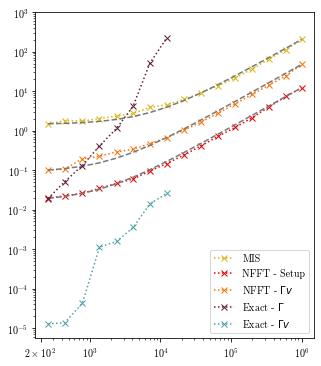

In [101]:
# Plot condition number against dimension
fig, ax = plt.subplots(1,1, figsize=(5,6))

# MIS
ax.loglog(n_dimensions, Window_finder, 'x:', color = 'xkcd:gold', label = 'MIS')
m_1 = ((n_dimensions[-1] - n_dimensions[0])/( Window_finder[-1] - Window_finder[0] ))**-1
b_1 = Window_finder[0] - m_1 * n_dimensions[0]
ax.loglog(n_dimensions, m_1 * n_dimensions + b_1, '--', color = '#787878')

# NFFT - Setup
ax.loglog(n_dimensions, Subkernel_time, 'x:', color = 'xkcd:red', label = 'NFFT - Setup')
m_1 = ((n_dimensions[-1] - n_dimensions[0])/( Subkernel_time[-1] - Subkernel_time[0] ))**-1
b_1 = Subkernel_time[0] - m_1 * n_dimensions[0]
ax.loglog(n_dimensions, m_1 * n_dimensions + b_1, '--', color = '#787878')

# NFFT - Γv
ax.loglog(n_dimensions, Operator_time, 'x:', color = 'xkcd:orange', label = 'NFFT - $\Gamma v$')
m_1 = ((n_dimensions[-1] - n_dimensions[0])/( Operator_time[-1] - Operator_time[0] ))**-1
b_1 = Operator_time[0] - m_1 * n_dimensions[0]
ax.loglog(n_dimensions, m_1 * n_dimensions + b_1, '--', color = '#787878')

# Explicit Γ
ax.loglog(n_dimensions, Full_Kernel_time, 'x:', color = '#611C35', label = 'Exact - $\Gamma$') # Tyrian purple
#b_1 = Full_Kernel_time[0] - MB[0] * n_dimensions[0]**2
#ax.loglog(n_dimensions[:8], MB[0] * n_dimensions[:8]**2 + b_1, '--', color = '#787878', alpha = 0.5)

# Explicit Γv
ax.loglog(n_dimensions, ANOVA_time, 'x:', color = '#4DA1A9', label = 'Exact - $\Gamma v$') # Moonstone
#m_1 = ((n_dimensions[7] - n_dimensions[0])/( ANOVA_time[7] - ANOVA_time[0] ))**-1
#b_1 = ANOVA_time[0] - m_1 * n_dimensions[0]
#ax.loglog(n_dimensions[:8], m_1 * n_dimensions[:8] + b_1, '--', color = '#787878', alpha = 0.5)

# Add more ticks in x-axis
ax_base = [2,3,4,5,6]
ax_val  = [2,1,1,1,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_xticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis
ax_base = [-5,-4,-3,-2,-1,0,1,2,3]
ax_val  = [1]*len(ax_base)
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Set legend
plt.legend(loc = 'lower right', prop = {'family':'CMR10'})

# –––––––– Store –––––––– #
fig.savefig('Operator_Times.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

---

The following table was done without repetitiong and averaging:

In [12]:
dims_images = []
n_dimensions = []
L_sizes = []

Patch_creation = []
Window_finder = []
Subkernel_time = []
Operator_time = []
Full_Kernel_time = []
ANOVA_time = []

print('–'*100)
for scale in Scales:
    # Scale image
    img = rescale(image, scale, anti_aliasing=True)
    img = asarray(img).astype(float, copy = False)
    N,M = img.shape
    nm  = img.size
    print(N,M,nm)
    dims_images.append((N,M))
    n_dimensions.append(nm)
    
    # Create noisy sample
    ## Fix seed
    rng = default_rng(10)
    σ_i = logspace(1,3,5)[3]
    f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f)
    print('{0:10} -> {1}'.format( around(σ_i,2), around(ssim(img, f, data_range=f.max()-f.min() ),2)  ))
    
    # Patch radius
    ρ = 3
    
    
    '''
        Kernel Setup
    '''
    def SSIM(img,u, N,M):  return ssim(img, u.reshape(N,M), data_range=u.max()-u.min())
    
    ρ̂    = 2*ρ+1
    
    """Patches"""
    start = time.time()
    Fᵖᵃᵈ = pad(f, ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    end = time.time()
    Patch_creation.append(end-start)
    
    '''Build windows'''
    window_scheme = 'mis'
    start = time.time()
    # determine windows of features by their mis
    if window_scheme == 'mis':
        res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
        windows = clf.get_mis_windows(res_idx)

    # windows are built following the feature indices in ascending order
    elif window_scheme == 'consec':
        d    = X.shape[1]
        windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

        # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
        if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

    # use predefined list of windows of features
    elif window_scheme == None:
        windows = pre_list
    end = time.time()
    
    num_windows = len(windows)
    Window_finder.append(end-start)
    L_sizes.append(num_windows)
    
    '''Weights'''
    # Select weight creation mode
    weight_scheme = 'equally weighted'

    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

    # Store weights efficiently as a view
    weights = broadcast_to(k_weight, (num_windows, ))
    
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows)]
    σ = 30.0
    
    start = time.time()
    SubKernels = W(σ, Other_Setup = 'default')
    end = time.time()
    Subkernel_time.append(end-start)

    def AK(u):
        """
        Approximate the matrix-vector product AK*u, where AK = w_1*K_1 + w_2*K_2 + ... + w_L*K_L.

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """

        # Apply matrix-vector multiplication
        subKernelProducts = asarray([SubKernels[l].apply(u) for l in range(num_windows)])

        # Multiply each subKernel by its weight and collect into a sum
        AKu = weights.dot(subKernelProducts)

        return AKu
    
    '''Kernel as an explicit object'''
    def Full_W(σ):
        A = [rbf_kernel(X[:,windows[l]], gamma = (σ**-2) ) for l in range(num_windows)]
        B = k_weight * asarray(A).sum(0)
        np.fill_diagonal(B, 0.0);
        return B
    
    if nm < 8670:
        start = time.time()
        ANOVA = Full_W(σ)
        end = time.time()
        Full_Kernel_time.append(end-start)
    
    # Define rhs
    u = f.ravel()/nm


    
    start = time.time()
    AK(u)
    end = time.time()
    Operator_time.append(end-start)
    
    if nm < 8670:
        start = time.time()
        ANOVA.dot(u)
        end = time.time()
        ANOVA_time.append(end-start)

    
    # Store images
    #imsave('brain_scaled_{0}.png'.format(scale), img.astype(np.uint8))
    #imsave('brain_scaled_noisy_{0}.png'.format(scale), f.astype(np.uint8))
    
    # Display evolution
    print(np.around(Patch_creation,4))
    print(np.around(Window_finder,4))
    print(np.around(Subkernel_time,4))
    print(np.around(Operator_time,4))
    print(np.around(Full_Kernel_time,4))
    print(np.around(ANOVA_time,4))
    
    print('–'*100 + '\n')

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
16 16 256
    316.23 -> 0.52
[0.0001]
[1.4267]
[0.0194]
[0.1877]
[0.0332]
[0.]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

21 21 441
    316.23 -> 0.54
[0.0001 0.0002]
[1.4267 1.6903]
[0.0194 0.0277]
[0.1877 0.1927]
[0.0332 0.051 ]
[0.     0.0017]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

28 28 784
    316.23 -> 0.49
[0.0001 0.0002 0.0003]
[1.4267 1.6903 1.743 ]
[0.0194 0.0277 0.0301]
[0.1877 0.1927 0.233 ]
[0.0332 0.051  0.1786]
[0.     0.0017 0.0002]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

37 37 1369
    316.23 -> 0.43
[0.0001 0.0002 0.0003 0.0003]
[1.4267 1.6903 1.743  1.922 ]
[0.0194 0.0277 0.0301 0.0387]
[0.1877 0.1927 0.233  0.2306]
[0.0332 0.051  0.1786 0.4851]
[0.     0.0017 0.0002 0.0028]
––––––––––––

In [16]:
df = df.round({'MIS': 2, 'NFFT Setup':2, 'Fast Γv':2, 'Cumulative':2, 'Explicit Γ':2, 'Cumulative E':2})
display(df)

,dims,n,L,Patch,MIS,NFFT Setup,Fast Γv,Cumulative,Explicit Γ,Exact Γv,Cumulative E
0,"(16, 16)",256,17,0.000133,1.43,0.02,0.19,0.21,0.03,0.000030,0.03
1,"(21, 21)",441,17,0.000235,1.69,0.03,0.19,0.22,0.05,0.001663,0.05
2,"(28, 28)",784,17,0.000285,1.74,0.03,0.23,0.26,0.18,0.000166,0.18
3,"(37, 37)",1369,17,0.000299,1.92,0.04,0.23,0.27,0.49,0.002847,0.49
4,"(49, 49)",2401,17,0.000535,2.30,0.05,0.19,0.24,1.35,0.000956,1.35
5,"(64, 64)",4096,17,0.000752,2.75,0.07,0.26,0.32,5.11,0.002502,5.11
6,"(84, 84)",7056,17,0.000833,3.73,0.10,0.71,0.81,41.48,0.007280,41.49
7,"(111, 111)",12321,17,0.002395,4.58,0.15,0.57,0.72,NaN,NaN,NaN
8,"(147, 147)",21609,17,0.004180,6.07,0.25,0.92,1.17,NaN,NaN,NaN
9,"(194, 194)",37636,17,0.005036,8.46,0.41,1.55,1.96,NaN,NaN,NaN


In [17]:
print(df.to_latex())

\begin{tabular}{llrrrrrrrrrr}
\toprule
{} &          dims &        n &   L &     Patch &     MIS &  NFFT Setup &  Fast Γv &  Cumulative &  Explicit Γ &  Exact Γv &  Cumulative E \\
\midrule
0  &      (16, 16) &      256 &  17 &  0.000133 &    1.43 &        0.02 &     0.19 &        0.21 &        0.03 &  0.000030 &          0.03 \\
1  &      (21, 21) &      441 &  17 &  0.000235 &    1.69 &        0.03 &     0.19 &        0.22 &        0.05 &  0.001663 &          0.05 \\
2  &      (28, 28) &      784 &  17 &  0.000285 &    1.74 &        0.03 &     0.23 &        0.26 &        0.18 &  0.000166 &          0.18 \\
3  &      (37, 37) &     1369 &  17 &  0.000299 &    1.92 &        0.04 &     0.23 &        0.27 &        0.49 &  0.002847 &          0.49 \\
4  &      (49, 49) &     2401 &  17 &  0.000535 &    2.30 &        0.05 &     0.19 &        0.24 &        1.35 &  0.000956 &          1.35 \\
5  &      (64, 64) &     4096 &  17 &  0.000752 &    2.75 &        0.07 &     0.26 &        0.32 &  

---

We performed additional tests for other choices of $\rho$ without averaging. These were exported to an excel file. Basically, if we divide the times by the number of windows, we obtain equivalent times across all measured quantities.

### $\rho=4$

In [18]:
dims_images = []
n_dimensions = []
L_sizes = []

Patch_creation = []
Window_finder = []
Subkernel_time = []
Operator_time = []
Full_Kernel_time = []
ANOVA_time = []

print('–'*100)
for scale in Scales:
    # Scale image
    img = rescale(image, scale, anti_aliasing=True)
    img = asarray(img).astype(float, copy = False)
    N,M = img.shape
    nm  = img.size
    print(N,M,nm)
    dims_images.append((N,M))
    n_dimensions.append(nm)
    
    # Create noisy sample
    ## Fix seed
    rng = default_rng(10)
    σ_i = logspace(1,3,5)[3]
    f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f)
    print('{0:10} -> {1}'.format( around(σ_i,2), around(ssim(img, f, data_range=f.max()-f.min() ),2)  ))
    
    # Patch radius
    ρ = 4
    
    
    '''
        Kernel Setup
    '''
    def SSIM(img,u, N,M):  return ssim(img, u.reshape(N,M), data_range=u.max()-u.min())
    
    ρ̂    = 2*ρ+1
    
    """Patches"""
    start = time.time()
    Fᵖᵃᵈ = pad(f, ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    end = time.time()
    Patch_creation.append(end-start)
    
    '''Build windows'''
    window_scheme = 'mis'
    start = time.time()
    # determine windows of features by their mis
    if window_scheme == 'mis':
        res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
        windows = clf.get_mis_windows(res_idx)

    # windows are built following the feature indices in ascending order
    elif window_scheme == 'consec':
        d    = X.shape[1]
        windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

        # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
        if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

    # use predefined list of windows of features
    elif window_scheme == None:
        windows = pre_list
    end = time.time()
    
    num_windows = len(windows)
    Window_finder.append(end-start)
    L_sizes.append(num_windows)
    
    '''Weights'''
    # Select weight creation mode
    weight_scheme = 'equally weighted'

    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

    # Store weights efficiently as a view
    weights = broadcast_to(k_weight, (num_windows, ))
    
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows)]
    σ = 30.0
    
    start = time.time()
    SubKernels = W(σ, Other_Setup = 'default')
    end = time.time()
    Subkernel_time.append(end-start)

    def AK(u):
        """
        Approximate the matrix-vector product AK*u, where AK = w_1*K_1 + w_2*K_2 + ... + w_L*K_L.

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """

        # Apply matrix-vector multiplication
        subKernelProducts = asarray([SubKernels[l].apply(u) for l in range(num_windows)])

        # Multiply each subKernel by its weight and collect into a sum
        AKu = weights.dot(subKernelProducts)

        return AKu
    
    '''Kernel as an explicit object'''
    def Full_W(σ):
        A = [rbf_kernel(X[:,windows[l]], gamma = (σ**-2) ) for l in range(num_windows)]
        B = k_weight * asarray(A).sum(0)
        np.fill_diagonal(B, 0.0);
        return B
    
    if nm < 8670:
        start = time.time()
        ANOVA = Full_W(σ)
        end = time.time()
        Full_Kernel_time.append(end-start)
    
    # Define rhs
    u = f.ravel()/nm


    
    start = time.time()
    AK(u)
    end = time.time()
    Operator_time.append(end-start)
    
    if nm < 8670:
        start = time.time()
        ANOVA.dot(u)
        end = time.time()
        ANOVA_time.append(end-start)

    
    # Store images
    #imsave('brain_scaled_{0}.png'.format(scale), img.astype(np.uint8))
    #imsave('brain_scaled_noisy_{0}.png'.format(scale), f.astype(np.uint8))
    
    # Display evolution
    print(np.around(Patch_creation,4))
    print(np.around(Window_finder,4))
    print(np.around(Subkernel_time,4))
    print(np.around(Operator_time,4))
    print(np.around(Full_Kernel_time,4))
    print(np.around(ANOVA_time,4))
    
    print('–'*100 + '\n')

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
16 16 256
    316.23 -> 0.52
[0.0245]
[1.8954]
[0.3705]
[0.2631]
[0.0315]
[0.]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

21 21 441
    316.23 -> 0.54
[0.0245 0.0002]
[1.8954 2.7332]
[0.3705 0.046 ]
[0.2631 0.2877]
[0.0315 0.1289]
[0. 0.]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

28 28 784
    316.23 -> 0.49
[0.0245 0.0002 0.0003]
[1.8954 2.7332 2.6677]
[0.3705 0.046  0.0531]
[0.2631 0.2877 0.2983]
[0.0315 0.1289 0.2376]
[0.     0.     0.0001]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

37 37 1369
    316.23 -> 0.43
[0.0245 0.0002 0.0003 0.0002]
[1.8954 2.7332 2.6677 3.013 ]
[0.3705 0.046  0.0531 0.0598]
[0.2631 0.2877 0.2983 0.3004]
[0.0315 0.1289 0.2376 0.7123]
[0.     0.     0.0001 0.0004]
––––––––––––––––––––

---

In [19]:
n_dimensions   = asarray(n_dimensions)
Patch_creation = asarray(Patch_creation)
Window_finder  = asarray(Window_finder)
Subkernel_time = asarray(Subkernel_time)
Operator_time  = asarray(Operator_time)

Full_Kernel_time = np.r_[Full_Kernel_time, [np.nan] * (Scales.size - len(ANOVA_time))]
ANOVA_time = np.r_[ANOVA_time, [np.nan] * (Scales.size - len(ANOVA_time))]

In [20]:
Data = {'dims':dims_images,
        'n':n_dimensions, 'L':L_sizes, 'Patch':Patch_creation, 'MIS':Window_finder, 'NFFT Setup':Subkernel_time, 
        'Fast Γv':Operator_time, 
        'Cumulative':(Patch_creation+Subkernel_time+Operator_time),
        'Explicit Γ':Full_Kernel_time,
        'Exact Γv':ANOVA_time,
        'Cumulative E': (Patch_creation+Full_Kernel_time+ANOVA_time)
       }

In [21]:
df = pd.DataFrame.from_dict(Data)

In [22]:
df = df.round({'MIS': 2, 'NFFT Setup':2, 'Fast Γv':2, 'Cumulative':2, 'Explicit Γ':2, 'Cumulative E':2})
display(df)

,dims,n,L,Patch,MIS,NFFT Setup,Fast Γv,Cumulative,Explicit Γ,Exact Γv,Cumulative E
0,"(16, 16)",256,27,0.024481,1.90,0.37,0.26,0.66,0.03,0.000027,0.06
1,"(21, 21)",441,27,0.000210,2.73,0.05,0.29,0.33,0.13,0.000046,0.13
2,"(28, 28)",784,27,0.000262,2.67,0.05,0.30,0.35,0.24,0.000140,0.24
3,"(37, 37)",1369,27,0.000160,3.01,0.06,0.30,0.36,0.71,0.000417,0.71
4,"(49, 49)",2401,27,0.000172,3.40,0.08,0.32,0.40,2.03,0.000942,2.03
5,"(64, 64)",4096,27,0.000400,4.46,0.11,0.42,0.53,6.57,0.002491,6.57
6,"(84, 84)",7056,27,0.000543,6.01,0.15,1.06,1.21,102.39,0.007443,102.40
7,"(111, 111)",12321,27,0.005494,7.37,0.25,0.96,1.21,NaN,NaN,NaN
8,"(147, 147)",21609,27,0.002310,9.87,0.40,1.56,1.97,NaN,NaN,NaN
9,"(194, 194)",37636,27,0.005595,13.93,0.68,2.63,3.31,NaN,NaN,NaN


In [23]:
print(df.to_latex())

\begin{tabular}{llrrrrrrrrrr}
\toprule
{} &          dims &        n &   L &     Patch &     MIS &  NFFT Setup &  Fast Γv &  Cumulative &  Explicit Γ &  Exact Γv &  Cumulative E \\
\midrule
0  &      (16, 16) &      256 &  27 &  0.024481 &    1.90 &        0.37 &     0.26 &        0.66 &        0.03 &  0.000027 &          0.06 \\
1  &      (21, 21) &      441 &  27 &  0.000210 &    2.73 &        0.05 &     0.29 &        0.33 &        0.13 &  0.000046 &          0.13 \\
2  &      (28, 28) &      784 &  27 &  0.000262 &    2.67 &        0.05 &     0.30 &        0.35 &        0.24 &  0.000140 &          0.24 \\
3  &      (37, 37) &     1369 &  27 &  0.000160 &    3.01 &        0.06 &     0.30 &        0.36 &        0.71 &  0.000417 &          0.71 \\
4  &      (49, 49) &     2401 &  27 &  0.000172 &    3.40 &        0.08 &     0.32 &        0.40 &        2.03 &  0.000942 &          2.03 \\
5  &      (64, 64) &     4096 &  27 &  0.000400 &    4.46 &        0.11 &     0.42 &        0.53 &  

---

### $\rho=2$

In [24]:
dims_images = []
n_dimensions = []
L_sizes = []

Patch_creation = []
Window_finder = []
Subkernel_time = []
Operator_time = []
Full_Kernel_time = []
ANOVA_time = []

print('–'*100)
for scale in Scales:
    # Scale image
    img = rescale(image, scale, anti_aliasing=True)
    img = asarray(img).astype(float, copy = False)
    N,M = img.shape
    nm  = img.size
    print(N,M,nm)
    dims_images.append((N,M))
    n_dimensions.append(nm)
    
    # Create noisy sample
    ## Fix seed
    rng = default_rng(10)
    σ_i = logspace(1,3,5)[3]
    f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f)
    print('{0:10} -> {1}'.format( around(σ_i,2), around(ssim(img, f, data_range=f.max()-f.min() ),2)  ))
    
    # Patch radius
    ρ = 2
    
    
    '''
        Kernel Setup
    '''
    def SSIM(img,u, N,M):  return ssim(img, u.reshape(N,M), data_range=u.max()-u.min())
    
    ρ̂    = 2*ρ+1
    
    """Patches"""
    start = time.time()
    Fᵖᵃᵈ = pad(f, ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    end = time.time()
    Patch_creation.append(end-start)
    
    '''Build windows'''
    window_scheme = 'mis'
    start = time.time()
    # determine windows of features by their mis
    if window_scheme == 'mis':
        res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
        windows = clf.get_mis_windows(res_idx)

    # windows are built following the feature indices in ascending order
    elif window_scheme == 'consec':
        d    = X.shape[1]
        windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

        # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
        if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

    # use predefined list of windows of features
    elif window_scheme == None:
        windows = pre_list
    end = time.time()
    
    num_windows = len(windows)
    Window_finder.append(end-start)
    L_sizes.append(num_windows)
    
    '''Weights'''
    # Select weight creation mode
    weight_scheme = 'equally weighted'

    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

    # Store weights efficiently as a view
    weights = broadcast_to(k_weight, (num_windows, ))
    
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows)]
    σ = 30.0
    
    start = time.time()
    SubKernels = W(σ, Other_Setup = 'default')
    end = time.time()
    Subkernel_time.append(end-start)

    def AK(u):
        """
        Approximate the matrix-vector product AK*u, where AK = w_1*K_1 + w_2*K_2 + ... + w_L*K_L.

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """

        # Apply matrix-vector multiplication
        subKernelProducts = asarray([SubKernels[l].apply(u) for l in range(num_windows)])

        # Multiply each subKernel by its weight and collect into a sum
        AKu = weights.dot(subKernelProducts)

        return AKu
    
    '''Kernel as an explicit object'''
    def Full_W(σ):
        A = [rbf_kernel(X[:,windows[l]], gamma = (σ**-2) ) for l in range(num_windows)]
        B = k_weight * asarray(A).sum(0)
        np.fill_diagonal(B, 0.0);
        return B
    
    if nm < 8670:
        start = time.time()
        ANOVA = Full_W(σ)
        end = time.time()
        Full_Kernel_time.append(end-start)
    
    # Define rhs
    u = f.ravel()/nm


    
    start = time.time()
    AK(u)
    end = time.time()
    Operator_time.append(end-start)
    
    if nm < 8670:
        start = time.time()
        ANOVA.dot(u)
        end = time.time()
        ANOVA_time.append(end-start)

    
    # Store images
    #imsave('brain_scaled_{0}.png'.format(scale), img.astype(np.uint8))
    #imsave('brain_scaled_noisy_{0}.png'.format(scale), f.astype(np.uint8))
    
    # Display evolution
    print(np.around(Patch_creation,4))
    print(np.around(Window_finder,4))
    print(np.around(Subkernel_time,4))
    print(np.around(Operator_time,4))
    print(np.around(Full_Kernel_time,4))
    print(np.around(ANOVA_time,4))
    
    print('–'*100 + '\n')

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
16 16 256
    316.23 -> 0.52
[0.0034]
[0.6087]
[0.4871]
[0.0934]
[0.0308]
[0.0002]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

21 21 441
    316.23 -> 0.54
[0.0034 0.0009]
[0.6087 1.1064]
[0.4871 0.0142]
[0.0934 0.1055]
[0.0308 0.0276]
[0.0002 0.    ]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

28 28 784
    316.23 -> 0.49
[0.0034 0.0009 0.0001]
[0.6087 1.1064 0.864 ]
[0.4871 0.0142 0.0167]
[0.0934 0.1055 0.0983]
[0.0308 0.0276 0.0553]
[0.0002 0.     0.0046]
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

37 37 1369
    316.23 -> 0.43
[0.0034 0.0009 0.0001 0.0004]
[0.6087 1.1064 0.864  1.0247]
[0.4871 0.0142 0.0167 0.021 ]
[0.0934 0.1055 0.0983 0.1109]
[0.0308 0.0276 0.0553 0.1967]
[0.0002 0.     0.0046 0.0004]
––––––––

---

In [25]:
n_dimensions   = asarray(n_dimensions)
Patch_creation = asarray(Patch_creation)
Window_finder  = asarray(Window_finder)
Subkernel_time = asarray(Subkernel_time)
Operator_time  = asarray(Operator_time)

Full_Kernel_time = np.r_[Full_Kernel_time, [np.nan] * (Scales.size - len(ANOVA_time))]
ANOVA_time = np.r_[ANOVA_time, [np.nan] * (Scales.size - len(ANOVA_time))]

In [26]:
Data = {'dims':dims_images,
        'n':n_dimensions, 'L':L_sizes, 'Patch':Patch_creation, 'MIS':Window_finder, 'NFFT Setup':Subkernel_time, 
        'Fast Γv':Operator_time, 
        'Cumulative':(Patch_creation+Subkernel_time+Operator_time),
        'Explicit Γ':Full_Kernel_time,
        'Exact Γv':ANOVA_time,
        'Cumulative E': (Patch_creation+Full_Kernel_time+ANOVA_time)
       }

In [27]:
df = pd.DataFrame.from_dict(Data)

In [28]:
df = df.round({'MIS': 2, 'NFFT Setup':2, 'Fast Γv':2, 'Cumulative':2, 'Explicit Γ':2, 'Cumulative E':2})
display(df)

,dims,n,L,Patch,MIS,NFFT Setup,Fast Γv,Cumulative,Explicit Γ,Exact Γv,Cumulative E
0,"(16, 16)",256,9,0.003436,0.61,0.49,0.09,0.58,0.03,0.000198,0.03
1,"(21, 21)",441,9,0.000935,1.11,0.01,0.11,0.12,0.03,0.000045,0.03
2,"(28, 28)",784,9,0.000096,0.86,0.02,0.10,0.12,0.06,0.004592,0.06
3,"(37, 37)",1369,9,0.000420,1.02,0.02,0.11,0.13,0.20,0.000353,0.20
4,"(49, 49)",2401,9,0.000342,1.21,0.03,0.10,0.12,0.70,0.000973,0.70
5,"(64, 64)",4096,9,0.000491,1.47,0.03,0.13,0.16,2.14,0.002638,2.14
6,"(84, 84)",7056,9,0.000404,1.98,0.05,0.19,0.24,4.53,0.007026,4.54
7,"(111, 111)",12321,9,0.001585,2.56,0.08,0.29,0.37,NaN,NaN,NaN
8,"(147, 147)",21609,9,0.002738,3.14,0.13,0.47,0.60,NaN,NaN,NaN
9,"(194, 194)",37636,9,0.010867,4.42,0.21,0.78,1.00,NaN,NaN,NaN


In [29]:
print(df.to_latex())

\begin{tabular}{llrrrrrrrrrr}
\toprule
{} &          dims &        n &  L &     Patch &     MIS &  NFFT Setup &  Fast Γv &  Cumulative &  Explicit Γ &  Exact Γv &  Cumulative E \\
\midrule
0  &      (16, 16) &      256 &  9 &  0.003436 &    0.61 &        0.49 &     0.09 &        0.58 &        0.03 &  0.000198 &          0.03 \\
1  &      (21, 21) &      441 &  9 &  0.000935 &    1.11 &        0.01 &     0.11 &        0.12 &        0.03 &  0.000045 &          0.03 \\
2  &      (28, 28) &      784 &  9 &  0.000096 &    0.86 &        0.02 &     0.10 &        0.12 &        0.06 &  0.004592 &          0.06 \\
3  &      (37, 37) &     1369 &  9 &  0.000420 &    1.02 &        0.02 &     0.11 &        0.13 &        0.20 &  0.000353 &          0.20 \\
4  &      (49, 49) &     2401 &  9 &  0.000342 &    1.21 &        0.03 &     0.10 &        0.12 &        0.70 &  0.000973 &          0.70 \\
5  &      (64, 64) &     4096 &  9 &  0.000491 &    1.47 &        0.03 &     0.13 &        0.16 &        2

---

In [57]:
n = np.asarray([256, 441, 784, 1369, 2401, 4096, 7056, 12321, 21609, 37636, 65536, 114244, 198916, 345744, 602176, 1002001])
T_NFFT = [0.21, 0.22, 0.26, 0.27, 0.24, 0.32, 0.81, 0.72, 1.17, 1.96, 3.36, 5.87, 10.22, 17.8, 32.26, 54.77]

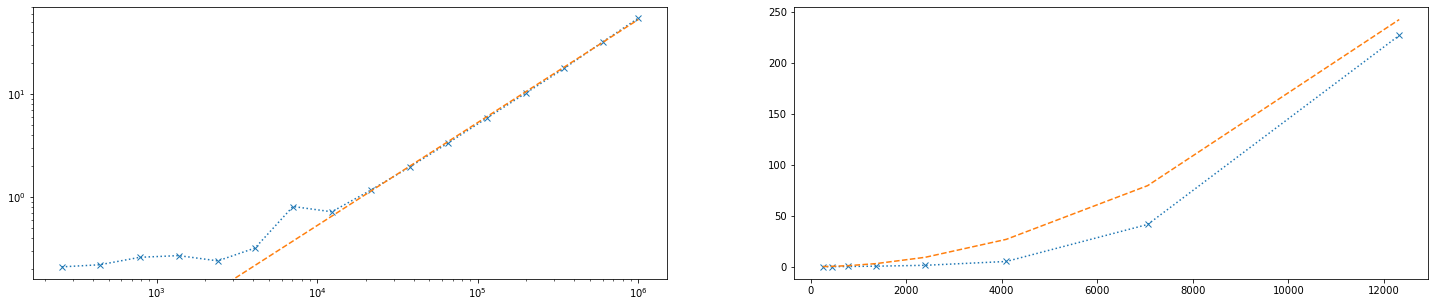

In [130]:
fig, ax = plt.subplots(1,2, facecolor='w', figsize=(25,5))

ax[0].loglog(n, T_NFFT, 'x:')
ax[0].loglog(n, 5.3e-05 * n, '--')      # (T_NFFT / n)[8:].mean()
ax[0].set_ylim(1.6e-1, 70)

ax[1].plot( n[:8], [0.03, 0.05, 0.18, 0.49, 1.35, 5.11, 41.49, 227.29], 'x:')
ax[1].plot( n[:8], 1.6e-06 * (n*n)[:8], '--')
plt.show()

---

## Storing images

```Python
from skimage.io import imsave

imsave('cell_small_noisy_upscaled.png', rescale(f, 1/0.1, anti_aliasing=True).astype(np.uint8))
plt.imshow(image, cmap='gray');    plt.axis('off');    plt.show()
```

---